# Baseline Segmentation with K-means Clustering

In [12]:
import glob
import pickle

import numpy as np

from matplotlib.image import imread
import matplotlib.pyplot as plt
from PIL import Image 

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

### Read images as arrays and re-scale

In [13]:
images_orig = [] #scaled (1024, 1024, 3)
images = [] #(1024*1024, 3)

files = glob.glob('/home/dssg-reglab/notebooks/home/segmentation_ground_truth/*.jpg')
for file in files:
    image = imread(file)
    #Normalization
    image = image/255 
    images_orig.append(image)
    images.append(image.reshape(-1, 3))

### Segmentation w/ K-means

In [14]:
def segment(image, k, shape):  
    km = KMeans(n_clusters = k)
    km.fit(image)
    centers = km.cluster_centers_

    #find brightest centroid
    brightest = max([sum(c) for c in centers]) 
    #set brightest centroid as 1 and others as 0
    new_centers = [0 for c in centers]
    for j, center in enumerate(centers):
        #set threshold of 1.5 for brightest - avoid classifying image w/ only dark background
        if sum(center) == brightest and brightest > 1.5:
            new_centers[j] = 1
    centers = new_centers
    centers = np.array(centers)
    
    #replace each pixel with the values of its cluster center (1 or 0)
    seg_image = centers[km.labels_]

    mask_proportion = np.sum(seg_image)/(shape[0]*shape[1]*1.0)
    #only detect cafos if predicted cafo proportion < 5% of image - avoid classifying image w/ white background/clouds
    if mask_proportion < 0.05:
        seg_image = seg_image.reshape(shape[0], shape[1])
    else:
        seg_image = np.zeros([shape[0], shape[1]])
        
    return seg_image

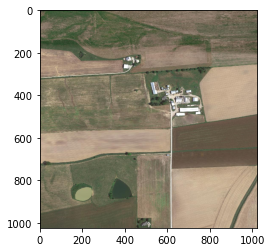

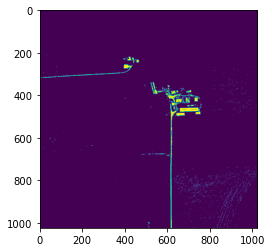

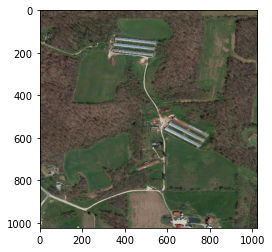

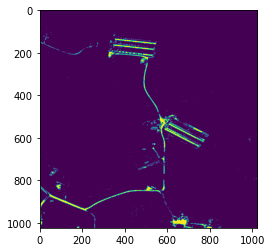

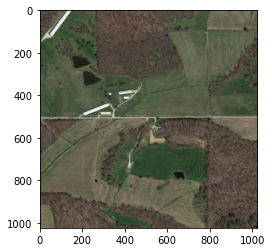

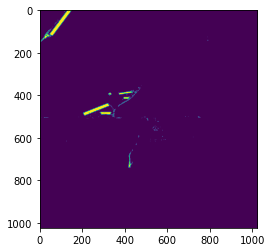

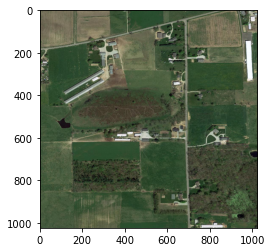

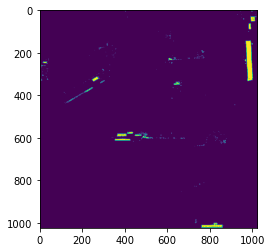

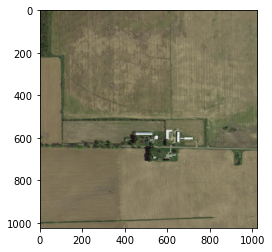

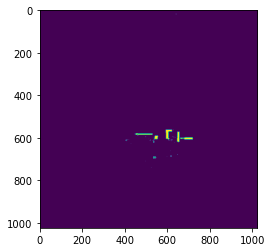

In [16]:
masks = []
for i, img in enumerate(images):
    plt.imshow(images_orig[i])
    plt.show()
    mask = segment(img, 7, [1024, 1024])
    masks.append(mask)
#    plt.savefig('../../segmented/' + str(i).zfill(3) + '.png', dpi=200)
    plt.imshow(mask)
    plt.show()
    if i == 4:
        break

# Validating against ground truth labels

### Load masks (ground truth)

In [5]:
#hack to load masks in right order
mturk_files = glob.glob('/home/dssg-reglab/notebooks/home/segmentation_ground_truth/*.jpg')

true_masks = []
for filename in mturk_files:
    filename = filename.replace('.jpg', '.p')
    ground_truth = pickle.load(open(filename, "rb" ))
    mask = ground_truth['masks']['CAFO Shed'] 
    true_masks.append(mask)

### Evaluation Metrics

In [6]:
pixel_accuracy = accuracy_score(np.concatenate(true_masks).flatten(), np.concatenate(masks).flatten())
precision = precision_score(np.concatenate(true_masks).flatten(), np.concatenate(masks).flatten())
recall = recall_score(np.concatenate(true_masks).flatten(), np.concatenate(masks).flatten())

SMOOTHING = 1
coeff_sum = 0
for i in range(len(masks)):
    pred_mask = masks[i]
    true_mask = true_masks[i]
    img = images[i] 
    intersection = np.logical_and(pred_mask, true_mask)
    union = np.logical_or(pred_mask, true_mask)
    coeff_sum += (intersection.sum() + SMOOTHING) / (union.sum() + SMOOTHING)
mean_iou = coeff_sum / len(masks)

print("Pixel accuracy: ", pixel_accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("Mean IOU: ", mean_iou)

Pixel accuracy:  0.9889983875410897
Precision:  0.23549972244832218
Recall:  0.5887025310198675
Mean IOU:  0.19856907413696698


# Prediction on satellite images

In [7]:
satellite_images_orig = [] #original
satellite_images = [] #reshaped
files = glob.glob('/home/dssg-reglab/notebooks/home/planet_images_il-latest/*')    

for file in files:
    image = imread(file)
    satellite_images_orig.append(image) 
    satellite_image = image.reshape(-1, img.shape[-1])
    satellite_images.append(satellite_image)

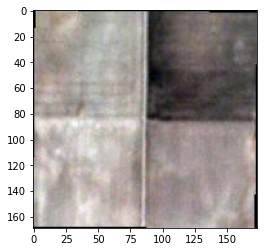

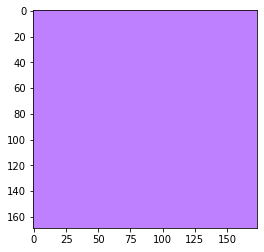

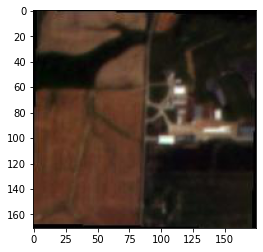

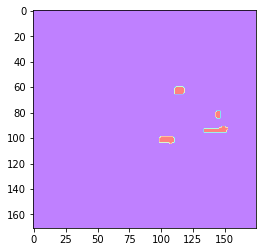

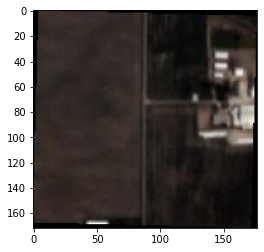

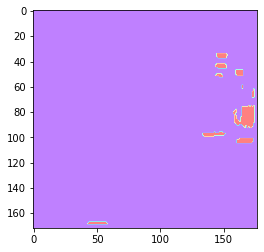

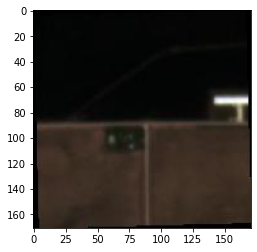

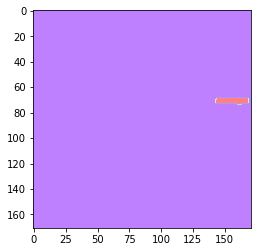

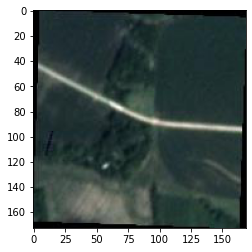

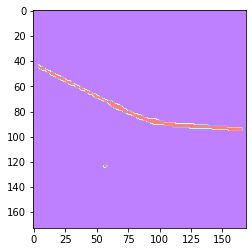

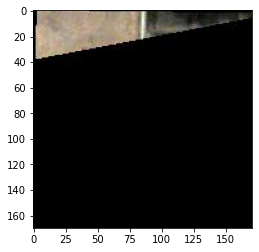

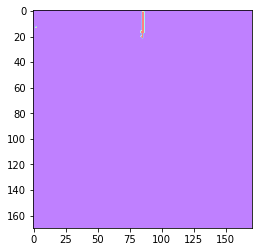

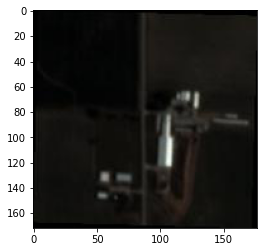

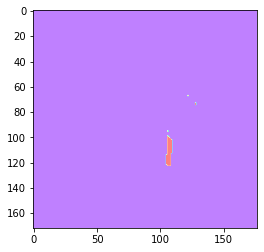

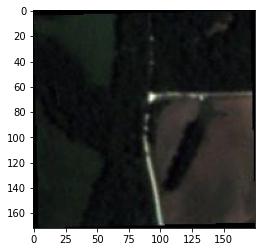

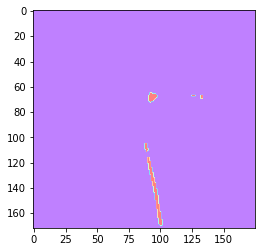

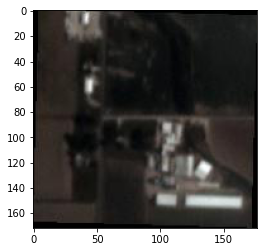

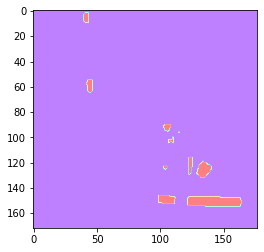

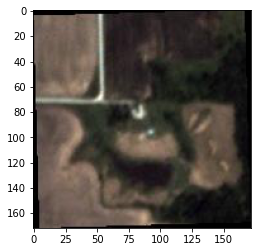

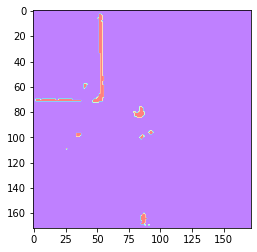

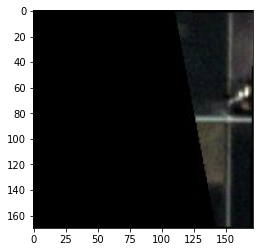

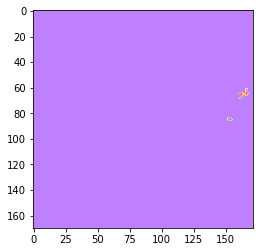

In [16]:
pred_masks = [] 
for i, img in enumerate(satellite_images):
    plt.imshow(satellite_images_orig[i])
    plt.show()
    mask = segment(img, 7, satellite_images_orig[i].shape)
    pred_masks.append(mask)
    plt.savefig('../../planet-segmented/' + str(i).zfill(3) + '.png', dpi=200)
    plt.imshow(mask, cmap='rainbow', alpha=.5)
    plt.show()
    if i == 10:
        break

In [17]:
files = glob.glob('/home/dssg-reglab/notebooks/home/data/raw/planet_images_il-2020/*')    

satellite_originals = []
satellite_images = []
for file in files:
    image = rasterio.open(file)
    r,g,b,n = image.read()
    image = np.stack((r,g,b), axis=2)
    #normalize
    image = image/image.max()
    satellite_originals.append(image)
    
    satellite_image = image.reshape(-1, image.shape[-1])
    satellite_images.append(satellite_image)


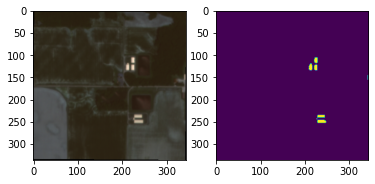

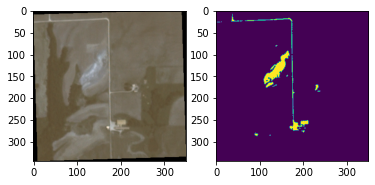

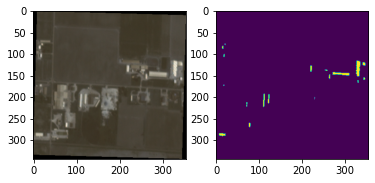

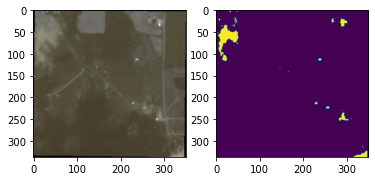

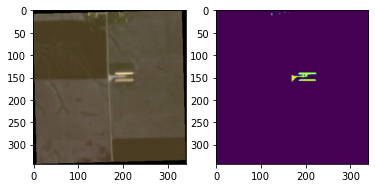

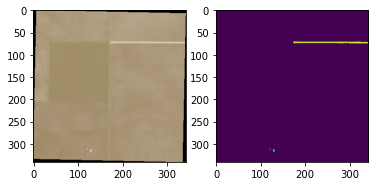

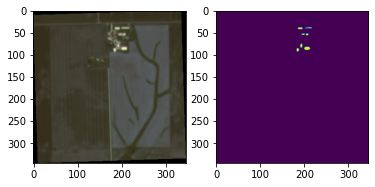

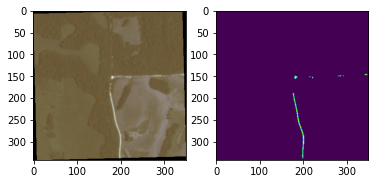

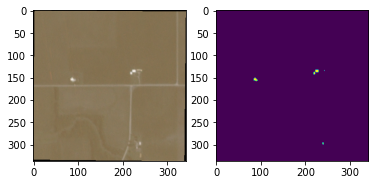

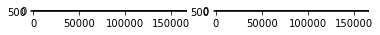

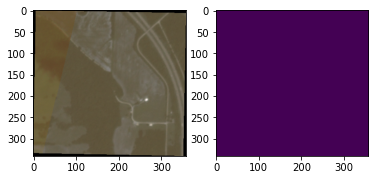

In [18]:
#pred_masks = [] 
for i, img in enumerate(satellite_images):
    f = plt.figure()
    ax1 = f.add_subplot(1,2,1)
    ax1 = ax1.imshow(satellite_images_orig[i])

    mask = segment(img, 7, satellite_images_orig[i].shape)
    ax2 = f.add_subplot(1,2,2)
    ax2 = ax2.imshow(mask)
    plt.show()
    
    if i == 10:
        break